<a href="https://colab.research.google.com/github/JheanmarcoOscanoa/Laboratorio-07/blob/main/Laboratorio_N%C2%B007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 07: Regresión Logística y Máquinas de Vectores de Soporte

**Autor:** Jheanmarco Oscanoa Vargas
**Curso:** Minería de Datos  
**Institución:** TECSUP  
**Semana:** 7  
**Tema:** Cálculo del Information Value, Regresión Logística y SVM

---

In [1]:
# Importar librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Parte a. Cálculo del Information Value (IV) y preparación de datos

En esta sección se calculará el `Information Value (IV)` para cada variable del dataset con el objetivo de evaluar su capacidad predictiva respecto a la variable objetivo (`clase`). Posteriormente, se excluirán aquellas variables con IV bajo (< 0.02) y se separarán los datos en entrenamiento y prueba para el modelado posterior.

###  a.1 Cargar y preprocesar los datos (limpieza)

In [12]:
def load_data(url):
    """
    Carga los datos desde el enlace proporcionado y asigna nombres de columnas.
    """
    column_names = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size',
                    'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size',
                    'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']

    df = pd.read_csv(url, names=column_names)
    return df


def clean_and_preprocess_data(df):
    """
    Realiza limpieza de datos, imputación de valores faltantes y codificación del target.
    """
    df_cleaned = df.copy()
    df_cleaned.replace('?', np.nan, inplace=True)
    df_cleaned['Bare Nuclei'] = pd.to_numeric(df_cleaned['Bare Nuclei'])
    df_cleaned['Bare Nuclei'].fillna(df_cleaned['Bare Nuclei'].median(), inplace=True)
    df_cleaned.drop(columns=['Sample code number'], inplace=True)
    df_cleaned['Class'] = df_cleaned['Class'].apply(lambda x: 1 if x == 4 else 0)  # 4 es maligno, 2 es benigno
    return df_cleaned


In [13]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
df_raw = load_data(url)
df = clean_and_preprocess_data(df_raw)
df.head()

<ipython-input-12-48c7ff43c8a2>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['Bare Nuclei'].fillna(df_cleaned['Bare Nuclei'].median(), inplace=True)


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,0
1,5,4,4,5,7,10.0,3,2,1,0
2,3,1,1,1,2,2.0,3,1,1,0
3,6,8,8,1,3,4.0,3,7,1,0
4,4,1,1,3,2,1.0,3,1,1,0


### a.2 Calcular el Information Value (IV)

In [18]:
def calcular_iv_variables(df, target='Class'):
    """
    Calcula el Information Value (IV) para cada variable respecto a la variable objetivo.
    """
    iv_dict = {}

    for col in df.drop(columns=[target]).columns:
        temp = pd.DataFrame({'variable': df[col], 'target': df[target]})
        grouped = temp.groupby('variable')['target']
        good = grouped.apply(lambda x: (x == 0).sum())
        bad = grouped.apply(lambda x: (x == 1).sum())
        dist_good = good / good.sum()
        dist_bad = bad / bad.sum()
        woe = np.log((dist_good + 1e-9) / (dist_bad + 1e-9))
        iv = ((dist_good - dist_bad) * woe).sum()
        iv_dict[col] = iv

    iv_df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=['IV']).sort_values(by='IV', ascending=False)
    return iv_df

iv_df = calcular_iv_variables(df)
iv_df

,IV
Uniformity of Cell Size,12.244475
Uniformity of Cell Shape,10.310095
Clump Thickness,8.917314
Bland Chromatin,7.909602
Normal Nucleoli,7.341471
Marginal Adhesion,5.747271
Bare Nuclei,5.726566
Single Epithelial Cell Size,4.072603
Mitoses,3.148193


### a.3 Visualizar el IV de forma clara

In [20]:
def plot_information_value(iv_df):
    """
    Visualiza los valores de Information Value con un gráfico de barras horizontal.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(x=iv_df['IV'], y=iv_df.index, palette="magma", edgecolor='black')
    plt.title("Information Value (IV) por variable", fontsize=14, weight='bold')
    plt.xlabel("IV", fontsize=12)
    plt.ylabel("Variable", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

<ipython-input-20-60b70a67f694>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=iv_df['IV'], y=iv_df.index, palette="magma", edgecolor='black')


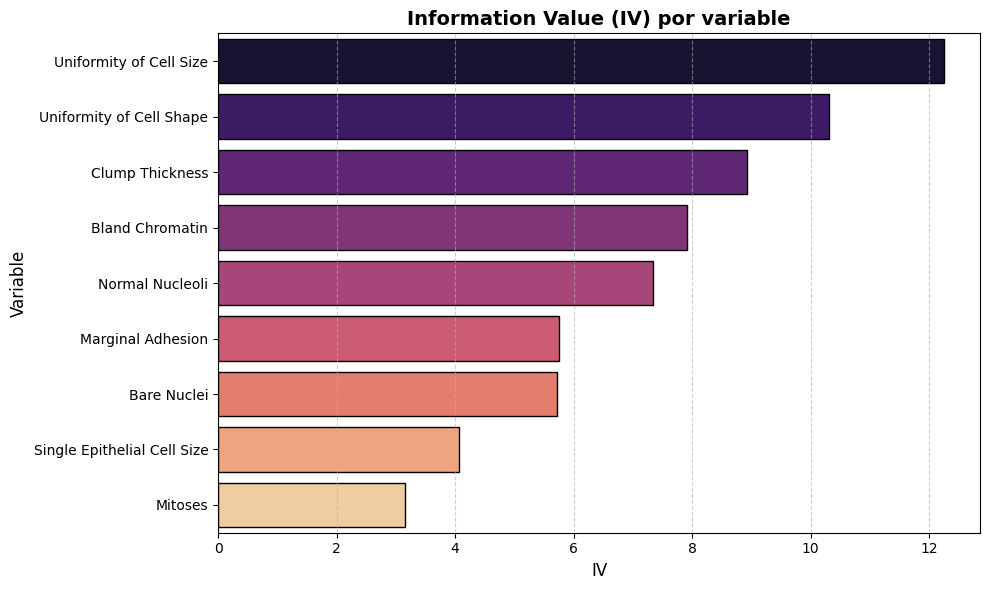

In [21]:
plot_information_value(iv_df)

### a.4 Eliminar variables con IV bajo y dividir dataset

In [22]:
def seleccionar_variables_relevantes(df, iv_df, threshold=0.02, target='Class'):
    """
    Selecciona variables con IV mayor al umbral y divide en conjunto de entrenamiento y prueba.
    """
    variables_seleccionadas = iv_df[iv_df['IV'] > threshold].index.tolist()
    X = df[variables_seleccionadas]
    y = df[target]
    return train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = seleccionar_variables_relevantes(df, iv_df)
X_train.shape, X_test.shape

((524, 9), (175, 9))

## Parte b - Modelo de Regresión Logística y Evaluación

### b.1 Entrenar modelo de regresión logística

In [24]:
from sklearn.linear_model import LogisticRegression

def entrenar_modelo_logistico(X_train, y_train):
    """
    Entrena un modelo de regresión logística con los datos de entrenamiento.

    Returns:
        modelo entrenado.
    """
    modelo = LogisticRegression(max_iter=1000, solver='liblinear')
    modelo.fit(X_train, y_train)
    return modelo

In [25]:
modelo_logistico = entrenar_modelo_logistico(X_train, y_train)

### b.2 Visualizar coeficientes y su importancia

In [26]:
def visualizar_coeficientes(modelo, feature_names):
    """
    Visualiza los coeficientes del modelo entrenado.
    """
    coef_df = pd.DataFrame({
        'Variable': feature_names,
        'Coeficiente': modelo.coef_[0]
    }).sort_values(by='Coeficiente', key=abs, ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coeficiente', y='Variable', data=coef_df, palette="coolwarm")
    plt.title("Importancia de Variables en Regresión Logística", fontsize=14, weight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return coef_df

<ipython-input-26-1d9ae5bb33e5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coeficiente', y='Variable', data=coef_df, palette="coolwarm")


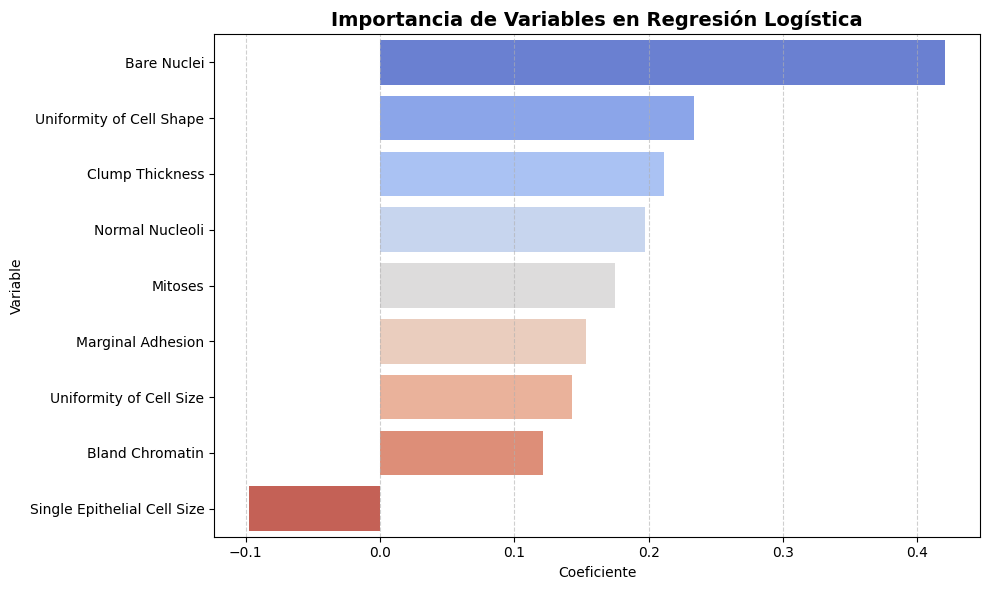

,Variable,Coeficiente
6,Bare Nuclei,0.420633
1,Uniformity of Cell Shape,0.233612
2,Clump Thickness,0.211164
4,Normal Nucleoli,0.197104
8,Mitoses,0.174639
5,Marginal Adhesion,0.153101
0,Uniformity of Cell Size,0.142539
3,Bland Chromatin,0.121402
7,Single Epithelial Cell Size,-0.097707


In [27]:
coeficientes_df = visualizar_coeficientes(modelo_logistico, X_train.columns)
coeficientes_df

## b.3 Evaluar métricas: accuracy, matriz de confusión, clasificación

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluar_modelo(modelo, X_train, y_train, X_test, y_test):
    """
    Evalúa el modelo en entrenamiento y prueba con métricas estándar.
    """
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    print("Precisión en Entrenamiento:", round(acc_train * 100, 2), "%")
    print("Precisión en Prueba:", round(acc_test * 100, 2), "%\n")
    print("Reporte de Clasificación (Prueba):\n", classification_report(y_test, y_pred_test))

    return y_test, y_pred_test

In [29]:
y_test_real, y_test_predicho = evaluar_modelo(modelo_logistico, X_train, y_train, X_test, y_test)

Precisión en Entrenamiento: 97.14 %
Precisión en Prueba: 94.29 %

Reporte de Clasificación (Prueba):
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       115
           1       0.95      0.88      0.91        60

    accuracy                           0.94       175
   macro avg       0.94      0.93      0.94       175
weighted avg       0.94      0.94      0.94       175



### b.4 Visualizar la matriz de confusión

In [30]:
def mostrar_matriz_confusion(y_real, y_predicho):
    """
    Dibuja la matriz de confusión con anotaciones.
    """
    cm = confusion_matrix(y_real, y_predicho)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Real")
    plt.title("Matriz de Confusión - Prueba")
    plt.tight_layout()
    plt.show()

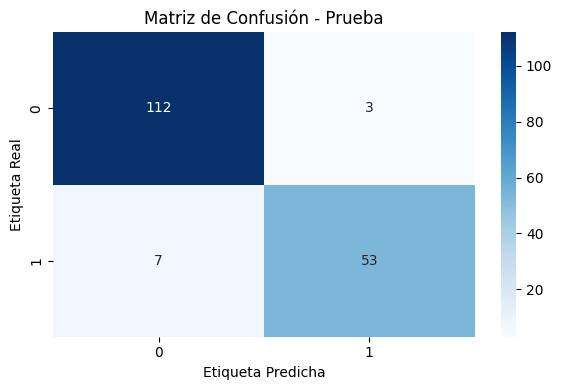

In [31]:
mostrar_matriz_confusion(y_test_real, y_test_predicho)

## Parte C: Implementación y Evaluación del Modelo SVM

### c.1. Entrenar el modelo SVM (Support Vector Machine)

In [32]:
from sklearn.svm import SVC

# Crear el modelo SVM con kernel lineal
modelo_svm = SVC(kernel='linear', random_state=42)

# Entrenar el modelo con los datos de entrenamiento
modelo_svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

### c.2 Evaluar el modelo SVM con las métricas

In [33]:
# Evaluar y mostrar métricas de desempeño
y_test_real_svm, y_test_predicho_svm = evaluar_modelo(modelo_svm, X_train, y_train, X_test, y_test)

Precisión en Entrenamiento: 97.14 %
Precisión en Prueba: 95.43 %

Reporte de Clasificación (Prueba):
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       115
           1       0.95      0.92      0.93        60

    accuracy                           0.95       175
   macro avg       0.95      0.95      0.95       175
weighted avg       0.95      0.95      0.95       175



### c.3. Visualizar la matriz de confusión del modelo SVM

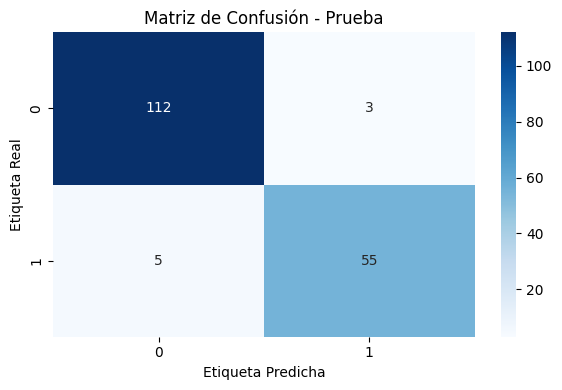

In [34]:
# Mostrar matriz de confusión
mostrar_matriz_confusion(y_test_real_svm, y_test_predicho_svm)